In [33]:
import math

import numpy as np
import pandas as pd
from seaborn import scatterplot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression



In [3]:
file = pd.read_csv("C:/Users/beryl/OneDrive/Desktop/ML_hw/project2/Data-Audit.csv")
file.dropna(inplace=True)
train_data, test_data = train_test_split(file, test_size=0.5, random_state=13)
X_train = train_data.drop(columns=['Risk'])
y_train = train_data['Risk']
X_test = test_data.drop(columns=['Risk'])
y_test = test_data['Risk']



## LINEAR PROBABILITY MODEL (LPM)

#### Threshold at 0.5

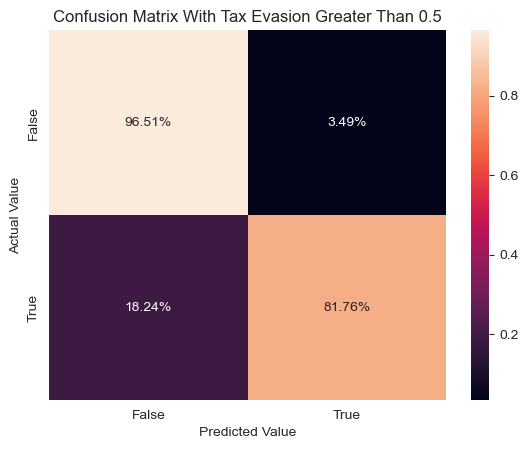

In [4]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
lpm_model = sm.OLS(y_train, X_train).fit()
lpm_pred = lpm_model.predict(X_test)
lpm_pred_bin_5 = np.where(lpm_pred > 0.5, 1, 0)
lpm_conf = confusion_matrix(y_test, lpm_pred_bin_5, normalize='true')
# print(lpm_conf)
heatmap = sns.heatmap(lpm_conf, annot=True, fmt=".2%")
heatmap.set_title("Confusion Matrix With Tax Evasion Greater Than 0.5")
heatmap.set_xlabel("Predicted Value")
heatmap.set_ylabel("Actual Value")
heatmap.xaxis.set_ticklabels(["False", "True"])
heatmap.yaxis.set_ticklabels(["False", "True"])
plt.show()
accuracy = accuracy_score(y_test, lpm_pred_bin_5)
error_5  = 1 - accuracy

#### Threshold at 0.6

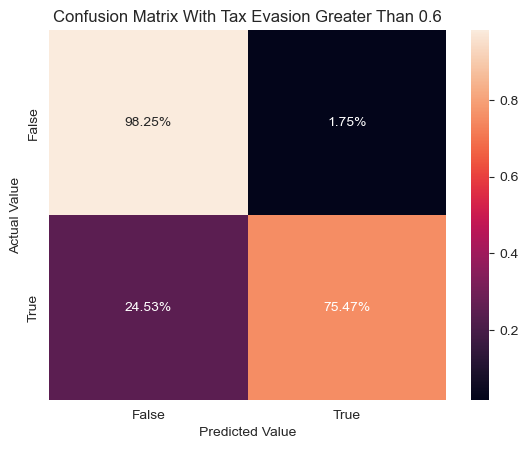

In [5]:
lpm_pred_bin_6 = np.where(lpm_pred > 0.6, 1, 0)
lpm_conf = confusion_matrix(y_test, lpm_pred_bin_6, normalize='true')
heatmap = sns.heatmap(lpm_conf, annot=True, fmt=".2%")
heatmap.set_title("Confusion Matrix With Tax Evasion Greater Than 0.6")
heatmap.set_xlabel("Predicted Value")
heatmap.set_ylabel("Actual Value")
heatmap.xaxis.set_ticklabels(["False", "True"])
heatmap.yaxis.set_ticklabels(["False", "True"])
plt.show()
accuracy = accuracy_score(y_test, lpm_pred_bin_6)
error_6 = 1-accuracy

In [7]:
print(f"The error rate for firms with a predicted probability of tax evasion greater than 0.5 is {error_5}")
print(f"The error rate for firms with a predicted probability of tax evasion greater than 0.6 is {error_6}")
print("The probability of 0.5 prediction has a lower error rate.")
print("For the 0.5 threshold, the True Positive rate is 81.76%. For the 0.6 threshold, the True Positive rate is 75.47%.")

The error rate for firms with a predicted probability of tax evasion greater than 0.5 is 0.09536082474226804
The error rate for firms with a predicted probability of tax evasion greater than 0.6 is 0.11082474226804129
The probability of 0.5 prediction has a lower error rate.
For the 0.5 threshold, the True Positive rate is 81.76%. For the 0.6 threshold, the True Positive rate is 75.47%.


### Plotting the ROC Curve
The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR). Instead of just two points (TPR at 0.5 and 0.6), the ROC curve shows the full spectrum of trade-offs between TPR and FPR for all thresholds.

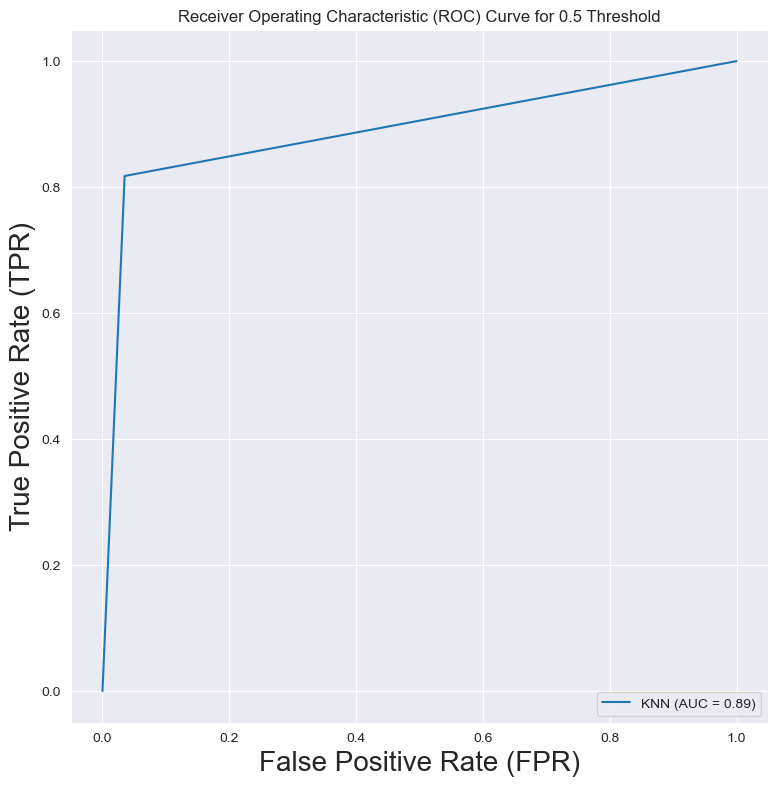

In [46]:
fpr_cv, tpr_cv, thresholds = roc_curve(y_test, lpm_pred_bin_5)
auc_cv = roc_auc_score(y_test, lpm_pred_bin_5)
roc_curve_cv = RocCurveDisplay(fpr=fpr_cv, tpr=tpr_cv,
                                roc_auc=auc_cv,
                                estimator_name='KNN')

fig, ax = plt.subplots(figsize=(9, 9))
roc_curve_cv.plot(ax=ax)
ax.set_ylabel("True Positive Rate (TPR)", fontsize=20)
ax.set_xlabel("False Positive Rate (FPR)", fontsize=20)
ax.set_title("Receiver Operating Characteristic (ROC) Curve for 0.5 Threshold")
plt.show()

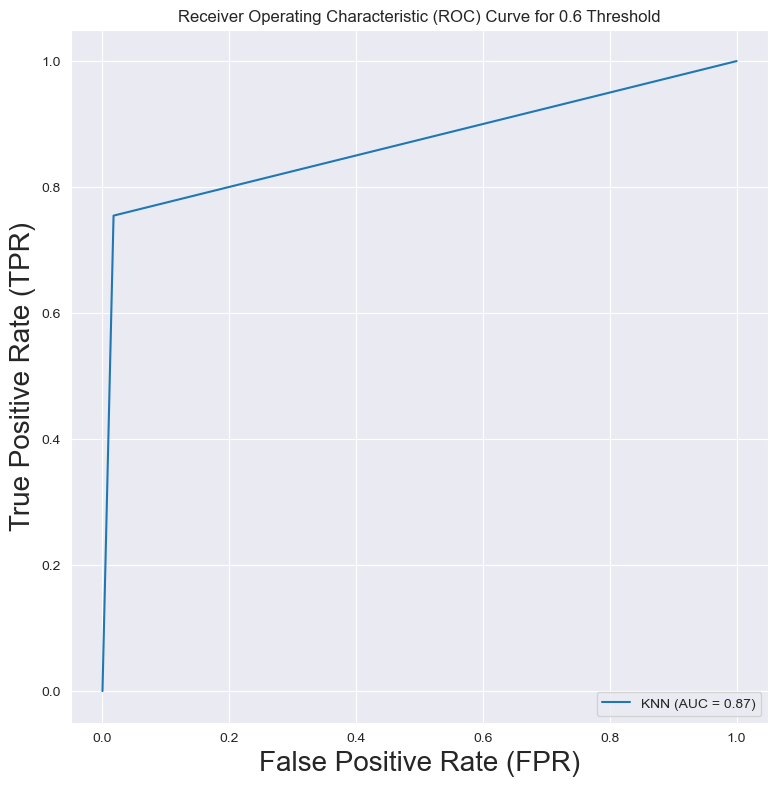

In [45]:
fpr_cv, tpr_cv, thresholds_cv = roc_curve(y_test, lpm_pred_bin_6)
auc_cv = roc_auc_score(y_test, lpm_pred_bin_6)
roc_curve_cv = RocCurveDisplay(fpr=fpr_cv, tpr=tpr_cv,
                                roc_auc=auc_cv,
                                estimator_name='KNN')

fig, ax = plt.subplots(figsize=(9, 9))
roc_curve_cv.plot(ax=ax)
ax.set_ylabel("True Positive Rate (TPR)", fontsize=20)
ax.set_xlabel("False Positive Rate (FPR)", fontsize=20)
ax.set_title("Receiver Operating Characteristic (ROC) Curve for 0.6 Threshold")
plt.show()

### Model Selection

False Positive is when someone not evades tax but be predicted as cheated. False Negative is when someone evades the tax but be predicted as not evaded the tax. In the context, False Negative is more important since we want to miss as fewer firms which cheated as possible. Setting the threshold of predicted probability of tax evasion will affect the false negative rate. When we set a lower value of threshold, we categorize firms with lower probability of cheated to be predicted as potential tax evader. In this way, we have lower false negative rate and higher false positive rate. We would like to choose a lower threshold, threshold at 0.5, to achieve a lower false negative rate. This model will provide a better prediction for tax evading.

## KNN MODEL

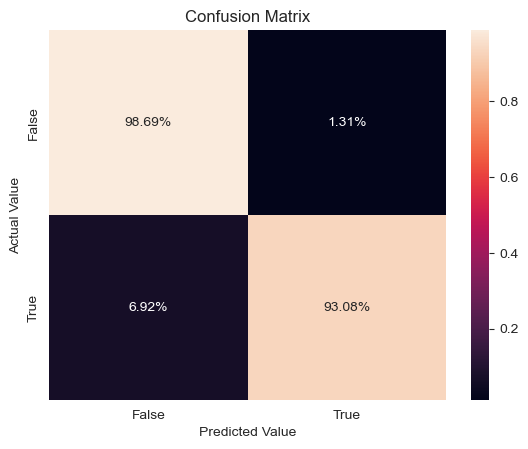

In [8]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train, y_train)
knn_5_pred = knn_5.predict(X_test)
knn_pred_bin_5 = np.where(knn_5_pred > 0.5, 1, 0)
cm_5 = confusion_matrix(y_test, knn_pred_bin_5, normalize='true')
cm_plt = sns.heatmap(cm_5, annot=True, fmt=".2%")
cm_plt.set_title("Confusion Matrix")
cm_plt.set_xlabel("Predicted Value")
cm_plt.set_ylabel("Actual Value")
cm_plt.xaxis.set_ticklabels(["False", "True"])
cm_plt.yaxis.set_ticklabels(["False", "True"])
plt.show()


In [12]:
accuracy = accuracy_score(y_test, knn_pred_bin_5)
error_knn_5 = 1 - accuracy
print(error_knn_5)

0.03608247422680411


The error rate is 0.036. It suggests about 3.6% of the data are miss classified.

In [23]:
cm_no_norm = confusion_matrix(y_test, knn_pred_bin_5)
true_positives = cm_no_norm[1,1]/(y_test==1).sum()
print(f"True Positive Rate (TPR) = {true_positives}")

True Positive Rate (TPR) = 0.9308176100628931


In [24]:
scaler = StandardScaler()
X = file.drop(columns=['Risk'])
y = file['Risk']
X_scaled = scaler.fit_transform(X)
cols = X.columns
X_final = pd.DataFrame(X_scaled, columns=cols)
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_final, y, test_size=0.5, random_state=13)

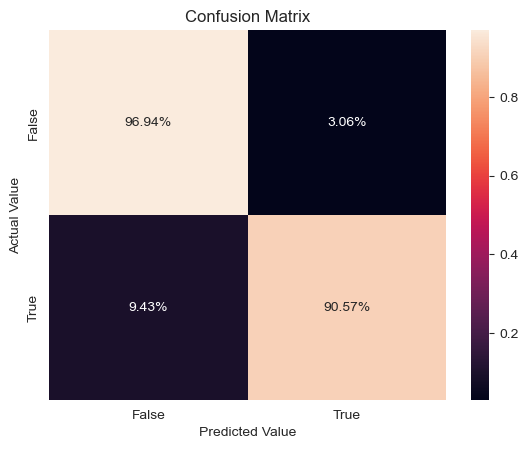

In [25]:
knn_scaler_5 = KNeighborsClassifier(n_neighbors=5)
knn_scaler_5.fit(x_train_scaled, y_train_scaled)
knn_scaler_5_pred = knn_scaler_5.predict(x_test_scaled)
cm_5 = confusion_matrix(y_test_scaled, knn_scaler_5_pred, normalize='true')
cm_plt = sns.heatmap(cm_5, annot=True, fmt=".2%")
cm_plt.set_title("Confusion Matrix")
cm_plt.set_xlabel("Predicted Value")
cm_plt.set_ylabel("Actual Value")
cm_plt.xaxis.set_ticklabels(["False", "True"])
cm_plt.yaxis.set_ticklabels(["False", "True"])
plt.show()


In [28]:
accuracy = accuracy_score(y_test_scaled, knn_scaler_5_pred)
error_knn_scaled_5 = 1 - accuracy
print(f"The error rate is {error_knn_scaled_5}, suggesting we misclassified 5.67% of the data.")

The error rate is 0.05670103092783507, suggesting we misclassified 5.67% of the data.


In [29]:
total_obs = y_test_scaled.shape[0]
scale_no_norm = confusion_matrix(y_test_scaled, knn_scaler_5_pred)
true_positives = scale_no_norm[1,1]/(y_test_scaled==1).sum()
true_positive_rate = true_positives * 100
print(f"{true_positive_rate:.2f} percent of the firms predicted to evade their taxes actually evaded taxes.")

90.57 percent of the firms predicted to evade their taxes actually evaded taxes.


The model without the predictors normalized performs better. It has lower error rate, lower false negative rate and higher true positive rate. The false negative rate for the not normalized model is about 2.5% lower than the normalized model, suggesting a better model performance in this scenario.

In [73]:
ks = list(range(1, 21, 2))
para = {'n_neighbors': ks}
knni = KNeighborsClassifier()
kfcv = KFold(n_splits=5, random_state=13, shuffle=True)
knn_cv = GridSearchCV(knni, para, cv=kfcv)
knn_cv.fit(X_train, y_train)
knn_cv_pred = knn_cv.predict(X_test)
knn_cv_pred_acc = accuracy_score(y_test, knn_cv_pred)
knn_cv_error = 1-knn_cv_pred_acc

print("Best parameters:", knn_cv.best_params_)
print("Best cross-validation score:", knn_cv.best_score_)
print("Error rate:", knn_cv_error)

Best parameters: {'n_neighbors': 1}
Best cross-validation score: 0.9638694638694638
Error rate: 0.04123711340206182


### Model Tuning
k = 1 yields the lowest error rate. This means that test sample is classified based on only its closest neighbor in the training set. There may exist clear pattern to seperate tax evading firms and non-evading firms.

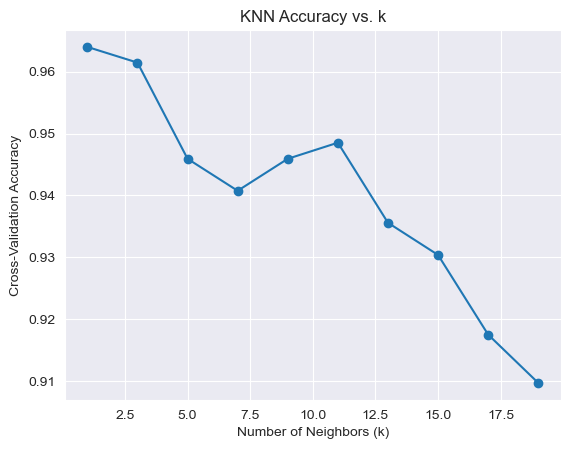

In [76]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

ks = list(range(1, 21, 2))  # Odd values of k from 1 to 19
cv_scores = []  # Store cross-validation scores

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5)  # 5-fold cross-validation
    cv_scores.append(scores.mean())

plt.plot(ks, cv_scores, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("KNN Accuracy vs. k")
plt.show()

#### Logistic Regression Model


In [44]:
train_data, test_data = train_test_split(file, test_size=0.3, random_state=42)
X_train = train_data.drop(columns=['Risk'])
y_train = train_data['Risk']
X_test = test_data.drop(columns=['Risk'])
y_test = test_data['Risk']

logitRegr = LogisticRegression()
logitRegr.fit(X_train, y_train)
y_prob = logitRegr.predict_proba(X_test)[:,1]
y_pred = (y_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
test_error = 1- accuracy
print(test_error)

0.03862660944206009


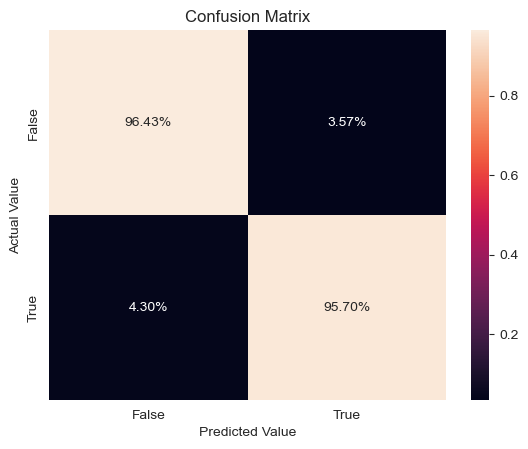

In [46]:
cm_log = confusion_matrix(y_test, y_pred, normalize='true')
cm_plt = sns.heatmap(cm_log, annot=True, fmt=".2%")
cm_plt.set_title("Confusion Matrix")
cm_plt.set_xlabel("Predicted Value")
cm_plt.set_ylabel("Actual Value")
cm_plt.xaxis.set_ticklabels(["False", "True"])
cm_plt.yaxis.set_ticklabels(["False", "True"])
plt.show()

The logistic regression model gives a overall error rate of 0.03862660944206009 with false negative rate of 4.3%.

### Problem Addressing
A major problem is selection bias. The data only includes firms that were audited. We don't know the performance of firms that were not audited. If government relied on this model, it may lead to audits being concentrated on firms that resemble past audited firm, even if they are not fraudulent. Also, if there's new fraud pattern, the model may fail to detect it.